<a href="https://colab.research.google.com/github/gibranfp/CursoAprendizajeAutomatizado/blob/master/notebooks/2d_reglogmult.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Regresión logística multinomial 
En esta libreta programaremos la regresión logística multinomial entrenada a través del descenso por gradiente. Probaremos nuestra implementación en dos tareas: clasificación de subespecies de la flor iris y clasificación de documentos por tema.

In [1]:
import scipy as sp
import numpy as np
import matplotlib.pyplot as plt

from sklearn.datasets import load_iris, fetch_20newsgroups
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, MaxAbsScaler

np.random.seed(123)

## Programación de funciones y clases
Definimos algunas funciones que utilizaremos para programar la regresión logística multinomial.

Para entrenar la regresión logística multinomial minimizamos la función de entropia cruzada, definida de la siguiente manera:

$$
E(\boldsymbol{\Theta})-\sum_{i=1}^n \sum_{k=1}^K [y^{(i)} = k] \log q^{(i)}_{k}
$$

donde 
$$
  q_{k}^{(i)} = softmax(\boldsymbol{\Theta}^T \mathbf{x}^{(i)})_k
$$


In [2]:
def entropia_cruzada(q, y):
  q[q==0] = np.nextafter(0,1)
  q[q==1] = np.nextafter(1,0)
  return np.sum(-np.log(q[np.nonzero(y)]))

Para $K$ clases distintas, $k \in [1, 2, \ldots, K]$ y 
$\mathbf{z} = \left[z_1, z_2, \ldots, z_K \right]$, la función $softmax$ está dada por
$$
softmax(\mathbf{z})_k = \frac{e^{z_k}}{\sum_{j=1}^{K} e^{z_j}} = \frac{e^{z_k - max(\mathbf{z})}}{\sum_{j=1}^{K} e^{z_j - max(\mathbf{z})}}
$$

In [3]:
def softmax(z):
  e_z = np.exp(z - np.max(z, axis = 1)[:, np.newaxis])
  norm = np.sum(e_z, axis = 1)
  return e_z / norm[:, np.newaxis]

El gradiente de la entropia cruzada respecto a $\boldsymbol{\Theta}$ para la clase $k$ es

$$
\nabla E(\boldsymbol{\Theta})_k  = \sum_{i=1}^n \left(q^{(i)}_{k} - \left[y^{(i)} = k\right]\right) \cdot \mathbf{x}^{(i)}
$$

Si presuponemos que $\mathbf{X}$ es la matriz de diseño que contiene un ejemplo en cada fila y codificamos las salidas con vectores fila de 1-de-K en $\mathbf{Y}$, podemos expresar el gradiente de todas las clases de forma matricial
$$
\nabla E(\boldsymbol{\Theta})  = \mathbf{X}^\top \left(\mathbf{Q} - \mathbf{Y}\right)
$$

donde $\mathbf{Q}$ es una matriz en la que cada fila corresponde a la salida de la función $softmax$ de un ejemplo.

In [4]:
def gradiente(X, Y, Q): 
  return X.T @  (Q - Y)

Entrenaremos nuestra regresión logística multinomial usando descenso por gradiente, cuya regla de actualización estaría dada por

$$
\boldsymbol{\Theta}^{[t + 1]}   = \boldsymbol{\Theta}^{[t]} - \alpha \nabla E(\boldsymbol{\Theta}^{[t]})
$$

$\alpha$ se conoce como tasa de aprendizaje.

El algoritmo del descenso del gradiente es el siguiente:

1. Inicializa parámetros aleatoriamente: 
2. Para $t = 1, 2, \ldots, n_{\text{iter}}$
  $$
  \boldsymbol{\Theta}^{[t + 1]}   = \boldsymbol{\Theta}^{[t]} - \alpha \nabla E(\boldsymbol{\Theta}^{[t]})
  $$

In [5]:
def descenso_gradiente(X, y, n_iter, tasa_ap):
  n_ej = X.shape[0]
  d = X.shape[1]
  n_clases = np.unique(y).size
  
  # Codifica clases con vectores 1-de-K
  Y_ohe = np.zeros((n_ej, n_clases))
  Y_ohe[np.arange(n_ej), y] = 1

  # Inicializa parámetros de forma aleatoria ("LeCun uniform")
  lim = np.sqrt(1 / d)
  parametros = np.random.uniform(-lim, lim, size=(d, n_clases))

  ecc = []
  for it in range(n_iter):
    Q = softmax(X @ parametros)
    parametros -= tasa_ap * gradiente(X, Y_ohe, Q)
    ecc.append(entropia_cruzada(Q, Y_ohe))

  return parametros, ecc

Definimos una función que calcula la exactitud para evaluar los modelos de clasificación, dada como el número de aciertos entre el número total de ejemplos.


In [6]:
def exactitud(y, y_predicha):
  return (y == y_predicha).mean()

Definimos nuestra clase de regresión logística multinomial.

In [7]:
class RegLogMult:
  def fit(self, X, y, n_iter=1000, tasa_ap=0.001):
    self.parametros_, errores = descenso_gradiente(X, y, n_iter, tasa_ap)
    return errores

  def predict(self, X):
    return softmax(X @ self.parametros_)
  
  def score(self, X, y):
    q = self.predict(X)
    return exactitud(y, np.argmax(q, axis=1))

## Clasificación de subespecies de la flor Iris
Probamos nuestra implementación en la tarea de clasificación de subespecies de la flor Iris. Usamos las funciones incluidas en _scikit-learn_ para cargar y dividir el conjunto de datos.

In [8]:
iris = load_iris()
X_iris = iris['data']
y_iris = iris['target']

X_iris_ent, X_iris_val, y_iris_ent, y_iris_val = train_test_split(X_iris,
                                                                  y_iris,
                                                                  test_size=0.3, 
                                                                  random_state=123)

Cuando entrenamos modelos a través del descenso por gradiente, es importante que los valores de todas las dimensiones de los vectores de ejemplo se encuentren en rangos similares. Para lograr esto, en algunas ocasiones es necesario escalar los ejemplos. 

In [9]:
sciris = MinMaxScaler()
X_iris_ent = sciris.fit_transform(X_iris_ent)
X_iris_val = sciris.transform(X_iris_val)

Creamos la matriz de diseño para los conjuntos de entrenamiento y validación.

In [10]:
ones_iris_ent = np.ones((X_iris_ent.shape[0], 1))
X_iris_ent = np.column_stack((ones_iris_ent, X_iris_ent))

ones_iris_val = np.ones(X_iris_val.shape[0])
X_iris_val = np.column_stack((ones_iris_val, X_iris_val))

Instanciamos y entrenamos el modelo.

In [11]:
rlm_iris = RegLogMult()
ec_iris = rlm_iris.fit(X_iris_ent, y_iris_ent, n_iter=100, tasa_ap=0.02)

Graficamos el error por iteración.

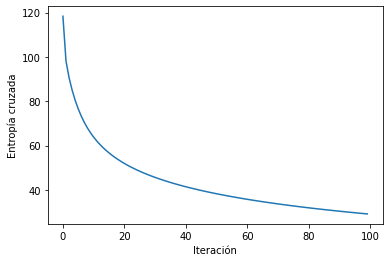

In [12]:
plt.plot(ec_iris)
plt.xlabel(u'Iteración')
plt.ylabel(u'Entropía cruzada')
plt.show()

Evaluamos el modelo con el conjunto de validación.

In [13]:
print('Exactitud = {0}'.format(rlm_iris.score(X_iris_val, y_iris_val)))

Exactitud = 0.9555555555555556


Debido a que son 3 clases, una predicción para una entrada $\mathbf{x}^{(i)}$ resulta en un vector $\mathbf{q}^{(i)} = [q_1, q_2, q_3], \sum_{i=1}^{3} q_i = 1$.

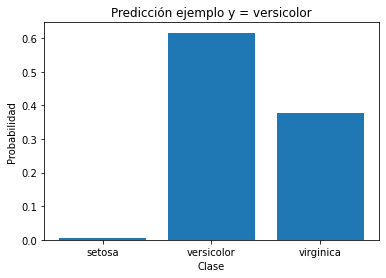

In [14]:
y_iris_pred = rlm_iris.predict(X_iris_val)
plt.bar(iris.target_names, y_iris_pred[0])
plt.xlabel('Clase')
plt.ylabel('Probabilidad')
plt.title('Predicción ejemplo y = ' + str(iris.target_names[y_iris_val[0]]))
plt.show()

## Clasificación de documentos por tema
También probaremos nuestra regresión logística multinomial en la clasificación de documentos por tema usando el conjunto de datos 20 newsgroups.

Nuevamente usaremos las funciones de _scikit-learn_ para descargar y dividir el conjunto datos de 20 newsgrops.

In [15]:
ng_ent = fetch_20newsgroups(subset='train', 
                            shuffle=True, 
                            random_state=123)

ng_val = fetch_20newsgroups(subset='test',
                            shuffle=True, 
                            random_state=123)

Obtenemos la representación vectorizada binaria de los documentos.

In [16]:
vec = CountVectorizer(max_features=10000,
                      stop_words='english', 
                      binary=True)

Esta representación es generalmente muy dispersa, por lo que `CountVectorizer` regresa una matriz tipo [CSR](https://docs.scipy.org/doc/scipy/reference/generated/scipy.sparse.csr_matrix.html ) (ver [_Sparse matrix_](https://en.wikipedia.org/wiki/Sparse_matrix)).

In [17]:
X_ng_ent = vec.fit_transform(ng_ent.data)
X_ng_val = vec.transform(ng_val.data)

Para matrices dispersas no es conveniente realizar escalado a través de estandarización o minmax, ya que rompen su dispersidad. Sin embargo, es posible escalar los valores manteniendo la dispersidad de las matrices dividiéndolos entre el valor absoluto máximo (en _scikit-learn_ es [MaxAbsScaler](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MaxAbsScaler.html)).

In [18]:
scng = MaxAbsScaler()
X_ng_ent = scng.fit_transform(X_ng_ent)
X_ng_val = scng.transform(X_ng_val)

Con los valores escalados creamos las matrices de diseño

In [19]:
ones_ng_ent = np.ones(X_ng_ent.shape[0])
X_ng_ent = sp.sparse.hstack((ones_ng_ent[:,None], X_ng_ent))

ones_ng_val = np.ones(X_ng_val.shape[0])
X_ng_val = sp.sparse.hstack((ones_ng_val[:,None], X_ng_val))

Obtenemos los vectores de salidas (clases)

In [20]:
y_ng_ent = ng_ent.target
y_ng_val = ng_val.target

Entrenamos nuestro modelo. Nota que la implementación de la regresión logística multinomial y del descenso por gradiente no cambia si tenemos matrices dispersas en los ejemplos.

In [21]:
rlm_ng = RegLogMult()
ec_ng = rlm_ng.fit(X_ng_ent, y_ng_ent, n_iter=100, tasa_ap=0.0006)

Graficamos el error por iteración

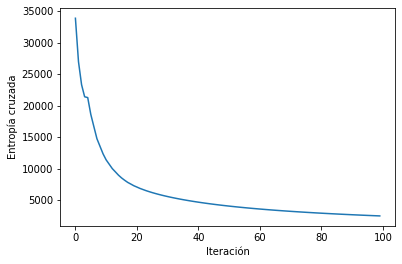

In [22]:
plt.plot(ec_ng)
plt.xlabel(u'Iteración')
plt.ylabel(u'Entropía cruzada')
plt.show()

Finalmente evaluamos el modelo entrenado en el conjunto de validación

In [23]:
print('Exactitud = {0}'.format(rlm_ng.score(X_ng_val, y_ng_val)))

Exactitud = 0.7955390334572491
